### 1. Purpose
The purpose of this document is to provide a set of problems to be solved by Vodafone Advanced Data Analytics
candidates as a means of skill assessment.
### 2. Instructions
Solve the problems as directed below.

#### 2.1. Code base
- Python>=3.6
- Include requirements.txt file in each repository

### 2.2. Submission
Each solution should be uploaded as a GitHub repository that will be deleted after
assessment.

Provide the repository links to repos in an email to mo.namazi@tpgtelecom.com.au and cc jiaxi.li@tpgtelecom.com.au / mahati.suvvari@tpgtelecom.com.au

#### 2.3. Data
The data for the problems can be found under the `data/` folder

#### 2.4. Guidelines
General solutions to these problems may be found available on the internet, feel free to
leverage these, however keep in mind we are looking for out-of-the-box thinking as well as
neat and scalable code.
Focus on the areas you are skilled in.
You will be asked to explain your code in full detail.
This is an opportunity to show your skills, as much as pass a test, we do not have perfect
solutions in mind.

### Dataset Description

We provide an open source dataset for cardiac arrhythmia classification. The dataset contains 452 patients and 279 attributes

The dataset is provided in 2 different files:
- `arrhythmia.data`

- `arrhythmia.names`

### Task 1 - Modelling

Build a standalone python program (.py) that can be executed in command-line (such as Terminal, Powershell, etc.).

`a.` Explore the dataset on the basic statistics, produce a classification model to predict the different classes of Arrhythmia, and present the findings as well as the performance of the model.

---

`Requirement.` **Using PySpark to build the application**

#TODO 
**the whole implementation can be found in apps folder**

### A Smaple of Reusults

In [ ]:
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import UnivariateFeatureSelector
import pandas as pd
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
#this function is specaily designed for the arraythmia dataset.
def load_arraythmia_data(path:str):
    try:
        print(path)
        df = pd.read_csv(path, header=None)
        print("INFO: the data is loaded.")

        #according to my analysis (in jupyter notebook), I decided to remove following columns
        df.drop(columns=[10, 11, 12, 13, 14], inplace=True)
        
        #next step, build labels. I wanted to convert the task to be a binary classification.
        binary_labels = []
        for label in df[279]:
            if label == 1:
                binary_labels.append(1)
            else:
                binary_labels.append(0)
        #now we need to drop the original labels
        df.drop(columns=[279], inplace = True)
        #convert dataframe to numpy array
        
        return df.to_numpy(), binary_labels
    except Exception as e:
        print(e)
        print("ERROR:the input file should be in csv format!")
        return None, None
    
def normalise_data(dataFrame, normalizer=None):


    if normalizer:
        normal = Normalizer(inputCol="features", outputCol="normFeatures", p=normalizer)
        return normal.transform(dataFrame)
    else:
        return dataFrame
    
def select_features(data):
    selector = UnivariateFeatureSelector(outputCol="selectedFeatures")
    selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(100)
    model = selector.fit(data)
    model.getFeaturesCol()
    return model.transform(data)

np_array, labels = load_arraythmia_data("data/arrhythmia.data")

list_tuples = []
for i in range(0, len(np_array)):
        list_tuples.append((labels[i],Vectors.dense(np_array[i])))
        
data = spark.createDataFrame(list_tuples, ["label", "features"])


#optional
dataFrame = normalise_data(data, 1.0)
sparkData = select_features(dataFrame)
    
#train, test = df_selected.randomSplit([0.9, 0.1], seed=12345)
split_point = int(0.1 * (len(np_array)))
test = spark.createDataFrame(sparkData.collect()[:split_point])

model_folder = "data/model/result/CrossValidationModel"
model = CrossValidatorModel.load(model_folder)
predictions = model.transform(test)


# scoreAndLabels = sc.parallelize([

In [47]:
y_test = []
predicts = []
for row in predictions.collect():
    y_test.append(row.label)
    predicts.append(int(row.prediction))

In [52]:
# class 1 is normal 

In [51]:
from sklearn.metrics import precision_recall_fscore_support
score = precision_recall_fscore_support(np.array(y_test), np.array(predicts), average=None )
score_t = np.transpose(np.array([score[0], score[1], score[2]]))
    
    
df = pd.DataFrame(score_t, columns = ['presision', 'recall', 'F1'])
df['class'] = [0,1]
df

,presision,recall,F1,class
0,0.812500,0.684211,0.742857,0
1,0.793103,0.884615,0.836364,1


class 0: has arrhythmia 
class 1: normal

As we can see from the above results, the recall value score of class 0 is very low. Unfortunately, for case like this, we would want higher recall scores on samples that may be arrhythmia.

To solve this issue:
1. change the classification threhold
2. increase the number of training samples in class 0 (this may be a bit difficult to acchive, if there is not change to collect more data. so maybe reduce the number of samples in class 1).


### Task 2 - Deployment

Build a controlled environment to package the above solution, so that this code and model could be easily executed in different platform and servers without manually resolving the dependencies/libraries.

- Build a container environment/application that the training and inferencing workflow could be executed separated in CLI.
- Make sure the application code is modular and easy to read by peers.

Note that, it is important to keep in mind that, the same code need to be executed in our environemnt without changing much to the code submitted.

---

`Hint.` To complete this task, it is expected to include the detailed steps of executing the build of the container environment.

`Requirement.` Using `spark-submit` to start/execute the scripts/application.

In [154]:
#TODO
#find the code in app folder

### Task 3 - Data Analytics

Build interesting insights that you could find from the provided dataset and/or the predictive results.

---

`Hint.` Insights could be presented with or without the results from `Task 1`. Feel free to use any tools and libraries to visualise the insights.

#TODO
1. age, heights, sex, weights, 
2. scalter, obeserve data outliers  

## Check class distributions

In [379]:
import pandas as pd
df_data = pd.read_csv('data/arrhythmia.data',  header=None)

df_data.groupby(df_data[279]).count().sort_values(0, ascending=False)[0]/len(df_data)

279
1     0.542035
10    0.110619
2     0.097345
6     0.055310
16    0.048673
3     0.033186
4     0.033186
5     0.028761
9     0.019912
15    0.011062
14    0.008850
7     0.006637
8     0.004425
Name: 0, dtype: float64

There are 16 diffrent calsses of this data set, however, as we can see that about 54% percent of the instances are normal, the rest of samples are in different levels of disorder. In this case, it would be a great challange to classify all 16 levels in one go because the data is extremely imbalanced. Therefore, I would like to initially treat this problem as a binary classification, to predict whether a pateint is normal or has arraythmia. 

## View data description

In [380]:
df_data.describe().T.sort_values('mean').to_csv('description.csv')

In [381]:
df_description = pd.read_csv('description.csv')
index_need_to_remove = df_description[df_description['mean'] == 0].index
df_data.drop(columns= index_need_to_remove, inplace = True)

In [382]:
df_data.to_csv('cleaned_data.csv')

## Handle missing data

In [383]:
no_of_nan = {}
for column in df_data.columns:
    no_of_nan[column] = len(df_data[df_data[column]== '?'])
sorted(no_of_nan.items(), key=lambda item: item[1], reverse=True)[:6]

[(13, 376), (11, 22), (10, 8), (12, 1), (14, 1), (0, 0)]

In [384]:
376/len(df_data)

0.831858407079646

Missing values are in column 11, 10, 12, 13, 14. 
we can see column 13 has over 83% missing data. 
These columns are Vector angles in degrees on front plane of:
10 QRS
11 T
12 P
13 QRST
14 JAs 
Seems like they are related, therefore, I decide to drop all of them.

In [385]:
df_data.drop(columns = [10, 11, 12, 13, 14], inplace=True)

Now, Lets build the new labels for the binary classification.


In [386]:
new_labels = []
#the last column records labels
for label in df_data[279].values:
    if label != 1:
        new_labels.append(0)
    else:
        new_labels.append(1)


In [387]:
#now I want to drop the label column to build the training data.
df_data.drop(columns = 279, inplace = True)

In [388]:
df_data.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,75,0,190,80,91,193,371,174,121,-16,...,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4
1,56,1,165,64,81,174,401,149,39,25,...,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8
2,54,0,172,95,138,163,386,185,102,96,...,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0
3,55,0,175,94,100,202,380,179,143,28,...,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6
4,75,0,190,80,88,181,360,177,103,-16,...,-0.4,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8


## Check personal information

Known the first 4 columns of the data are:

      1 Age: Age in years , linear
      2 Sex: Sex (0 = male; 1 = female) , nominal
      3 Height: Height in centimeters , linear
      4 Weight: Weight in kilograms , lineardf_person = df_data[[0, 1, 2, 3]]
df_person.rename(columns = {0:'Age', 1:'Sex', 2:'Height', 3:'Weight'}, inplace=True)
      
      
I am quite curious if there are any correlations between them an arrhythmia.

In [389]:
#give columns names to intrested columns
df_person = df_data[[0, 1, 2, 3]]
df_person.rename(columns = {0:'Age', 1:'Sex', 2:'Height', 3:'Weight'}, inplace=True)

/var/folders/nr/n2gb5q9x2cjg8v0ly8k8xtgc0000gn/T/ipykernel_13270/1133641437.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_person.rename(columns = {0:'Age', 1:'Sex', 2:'Height', 3:'Weight'}, inplace=True)


In [390]:
df_person['Age'].describe()

count    452.000000
mean      46.471239
std       16.466631
min        0.000000
25%       36.000000
50%       47.000000
75%       58.000000
max       83.000000
Name: Age, dtype: float64

LOOKS OK

In [391]:
df_person.groupby('Sex').count()

,Age,Height,Weight
Sex,,,
0,203,203,203
1,249,249,249


In [392]:
249/len(df_person)

0.5508849557522124

In [393]:

from sklearn.preprocessing import normalize
from pyspark.ml.linalg import Vectors
def prepare_data(rawData, normalizer=None):
    if normalizer:
        return normalize(rawData, norm=normalizer)
    else:
        return rawData
    
array = prepare_data(df_data.to_numpy(), normalizer = None)
list_tuples = []
for i in range(0, len(array)):
    list_tuples.append((new_labels[i],Vectors.dense(array[i])))
data = spark.createDataFrame(list_tuples, ["label", "features"])
data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[75.0,0.0,190.0,8...|
|    0|[56.0,1.0,165.0,6...|
|    0|[54.0,0.0,172.0,9...|
|    1|[55.0,0.0,175.0,9...|
|    0|[75.0,0.0,190.0,8...|
|    0|[13.0,0.0,169.0,5...|
|    1|[40.0,1.0,160.0,5...|
|    1|[49.0,1.0,162.0,5...|
|    1|[44.0,0.0,168.0,5...|
|    0|[50.0,1.0,167.0,6...|
|    0|[62.0,0.0,170.0,7...|
|    1|[45.0,1.0,165.0,8...|
|    0|[54.0,1.0,172.0,5...|
|    0|[30.0,0.0,170.0,7...|
|    1|[44.0,1.0,160.0,8...|
|    1|[47.0,1.0,150.0,4...|
|    0|[47.0,0.0,171.0,5...|
|    1|[46.0,1.0,158.0,5...|
|    1|[73.0,0.0,165.0,6...|
|    1|[57.0,1.0,166.0,7...|
+-----+--------------------+
only showing top 20 rows



I also want to do feature selections

In [394]:
from pyspark.ml.feature import UnivariateFeatureSelector
selector = UnivariateFeatureSelector(outputCol="selectedFeatures")
selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(100)
model = selector.fit(data)
model.getFeaturesCol()
df_selected = model.transform(data)

In [395]:
df_selected.select('features', 'selectedFeatures').show()

+--------------------+--------------------+
|            features|    selectedFeatures|
+--------------------+--------------------+
|[75.0,0.0,190.0,8...|[0.0,91.0,174.0,4...|
|[56.0,1.0,165.0,6...|[1.0,81.0,149.0,0...|
|[54.0,0.0,172.0,9...|[0.0,138.0,185.0,...|
|[55.0,0.0,175.0,9...|[0.0,100.0,179.0,...|
|[75.0,0.0,190.0,8...|[0.0,88.0,177.0,4...|
|[13.0,0.0,169.0,5...|[0.0,100.0,174.0,...|
|[40.0,1.0,160.0,5...|[1.0,77.0,133.0,0...|
|[49.0,1.0,162.0,5...|[1.0,78.0,157.0,3...|
|[44.0,0.0,168.0,5...|[0.0,84.0,160.0,0...|
|[50.0,1.0,167.0,6...|[1.0,89.0,156.0,4...|
|[62.0,0.0,170.0,7...|[0.0,102.0,156.0,...|
|[45.0,1.0,165.0,8...|[1.0,77.0,150.0,2...|
|[54.0,1.0,172.0,5...|[1.0,78.0,163.0,0...|
|[30.0,0.0,170.0,7...|[0.0,91.0,157.0,0...|
|[44.0,1.0,160.0,8...|[1.0,77.0,163.0,0...|
|[47.0,1.0,150.0,4...|[1.0,75.0,169.0,0...|
|[47.0,0.0,171.0,5...|[0.0,82.0,169.0,0...|
|[46.0,1.0,158.0,5...|[1.0,70.0,122.0,0...|
|[73.0,0.0,165.0,6...|[0.0,91.0,175.0,5...|
|[57.0,1.0,166.0,7...|[1.0,82.0,

In [396]:
df_person['label'] = new_labels

/var/folders/nr/n2gb5q9x2cjg8v0ly8k8xtgc0000gn/T/ipykernel_13270/893380712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_person['label'] = new_labels


In [397]:
df_person.head()

,Age,Sex,Height,Weight,label
0,75,0,190,80,0
1,56,1,165,64,0
2,54,0,172,95,0
3,55,0,175,94,1
4,75,0,190,80,0


In [398]:
df_person['Age'].describe()

count    452.000000
mean      46.471239
std       16.466631
min        0.000000
25%       36.000000
50%       47.000000
75%       58.000000
max       83.000000
Name: Age, dtype: float64

LOOKS OK

In [399]:
df_person.groupby('Sex').count()

,Age,Height,Weight,label
Sex,,,,
0,203,203,203,203
1,249,249,249,249


55% of samples are woman, 45% of samples are men

In [400]:
df_person['Height'].describe()

count    452.000000
mean     166.188053
std       37.170340
min      105.000000
25%      160.000000
50%      164.000000
75%      170.000000
max      780.000000
Name: Height, dtype: float64

In [401]:
df_person.groupby('Height').count().tail()

,Age,Sex,Weight,label
Height,,,,
186,3,3,3,3
188,1,1,1,1
190,3,3,3,3
608,1,1,1,1
780,1,1,1,1


when I check the height, there are two outiers: 780 and 608. 

In [402]:
df_person[df_person['Height']>200]

,Age,Sex,Height,Weight,label
141,1,1,780,6,0
316,0,0,608,10,0


See their ages are 1 and 0, I think the height should be in mm.

In [403]:
df_data[2][141]=78
df_data[2][316]=60.8
df_person['Height'][141]=78
df_person['Height'][316]=60.8

/var/folders/nr/n2gb5q9x2cjg8v0ly8k8xtgc0000gn/T/ipykernel_13270/2250411886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[2][141]=78
/var/folders/nr/n2gb5q9x2cjg8v0ly8k8xtgc0000gn/T/ipykernel_13270/2250411886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[2][316]=60.8
/var/folders/nr/n2gb5q9x2cjg8v0ly8k8xtgc0000gn/T/ipykernel_13270/2250411886.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_person['Heig

Next, I want to view the age and heighs distributions

In [404]:
df_person['Weight'].describe()

count    452.000000
mean      68.170354
std       16.590803
min        6.000000
25%       59.000000
50%       68.000000
75%       79.000000
max      176.000000
Name: Weight, dtype: float64

The max weight is 176 kg. still sounds reasonable to me.

In [405]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

bin_labels = ['0-10','10-20','20-30','30-40','40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
df_person['AgeGroup'] = pd.cut(df_person['Age'], bins=bins, labels=bin_labels, right=False)



/var/folders/nr/n2gb5q9x2cjg8v0ly8k8xtgc0000gn/T/ipykernel_13270/3286714148.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_person['AgeGroup'] = pd.cut(df_person['Age'], bins=bins, labels=bin_labels, right=False)


In [406]:
bins = [0, 100, 140, 150, 160, 170, 180, 190, 200]

bin_labels = ['0-100cm','100-140cm','140-150cm', '150-160cm','160-170cm','170-180cm', '180-190cm', '190-200cm']
df_person['HeightGroup'] = pd.cut(df_person['Height'], bins=bins, labels=bin_labels, right=False)

/var/folders/nr/n2gb5q9x2cjg8v0ly8k8xtgc0000gn/T/ipykernel_13270/905121470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_person['HeightGroup'] = pd.cut(df_person['Height'], bins=bins, labels=bin_labels, right=False)


In [407]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

bin_labels = ['0-10','10-20','20-30','30-40','40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100 Above']
df_person['WeightGroup'] = pd.cut(df_person['Weight'], bins=bins, labels=bin_labels, right=False)

/var/folders/nr/n2gb5q9x2cjg8v0ly8k8xtgc0000gn/T/ipykernel_13270/1697154934.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_person['WeightGroup'] = pd.cut(df_person['Weight'], bins=bins, labels=bin_labels, right=False)


In [408]:
df_height = df_person.groupby('HeightGroup').count().rename(columns={'Age':'number'})[['number']]
df_age = df_person.groupby('AgeGroup').count().rename(columns={'Age':'number'})[['number']]
df_weight = df_person.groupby('WeightGroup').count().rename(columns={'Age':'number'})[['number']]

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

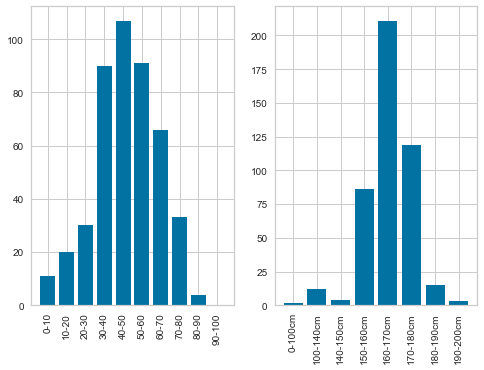

In [409]:
import matplotlib.pyplot as plt
import numpy as np

plt.subplot(1,2,1)
agegroup = df_age.index
numbers = df_age['number']
plt.bar(agegroup,numbers)
plt.xticks(rotation = 90)

plt.subplot(1,2,2)
heightgroup = df_height.index
numbers = df_height['number']
plt.bar(heightgroup,numbers)
plt.xticks(rotation = 90)



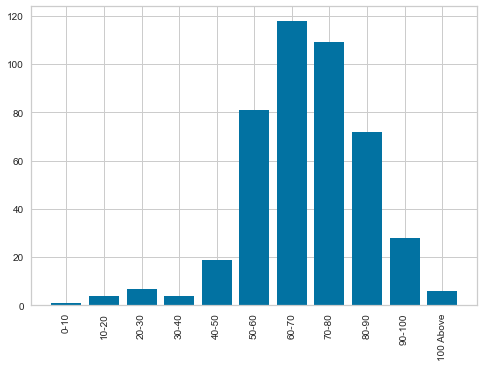

In [410]:
weightgroup = df_weight.index
numbers = df_weight['number']
plt.bar(weightgroup,numbers)
plt.xticks(rotation = 90)
plt.show()

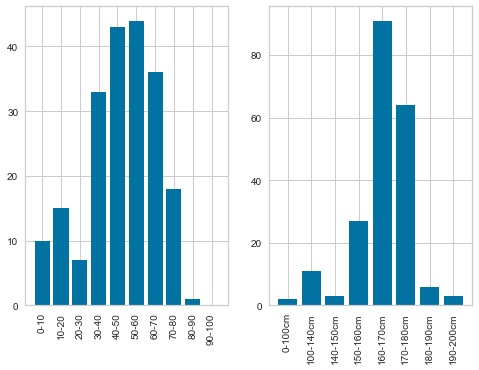

In [411]:
df_height_sick = df_person[df_person['label'] == 0].groupby('HeightGroup').count().rename(columns={'Age':'number'})[['number']]
df_age_sick = df_person[df_person['label'] == 0].groupby('AgeGroup').count().rename(columns={'Age':'number'})[['number']]


plt.subplot(1,2,1)
agegroup = df_age_sick.index
numbers = df_age_sick['number']
plt.bar(agegroup,numbers)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
heightgroup = df_height_sick.index
numbers = df_height_sick['number']
plt.bar(heightgroup,numbers)
plt.xticks(rotation = 90)
plt.show()

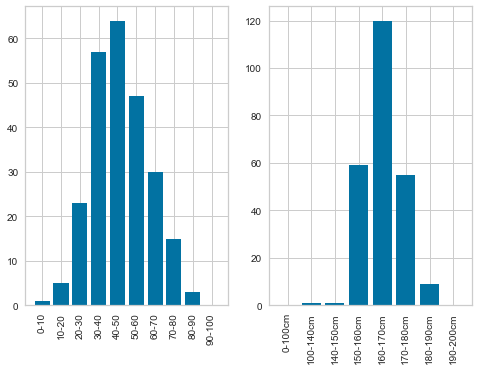

In [412]:
df_height_normal = df_person[df_person['label'] ==1].groupby('HeightGroup').count().rename(columns={'Age':'number'})[['number']]
df_age_normal = df_person[df_person['label'] == 1].groupby('AgeGroup').count().rename(columns={'Age':'number'})[['number']]


plt.subplot(1,2,1)
agegroup = df_age_normal.index
numbers = df_age_normal['number']
plt.bar(agegroup,numbers)
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
heightgroup = df_height_normal.index
numbers = df_height_normal['number']
plt.bar(heightgroup,numbers)
plt.xticks(rotation = 90)
plt.show()

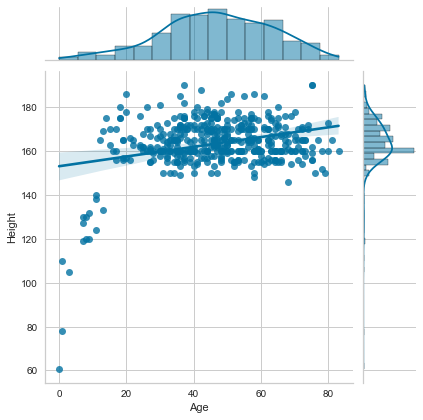

In [413]:
import seaborn as sns
#sns.scatterplot(x="Age", y="Height", data=df_person)
sns.jointplot(x="Age", 
              y="Height",
              kind="reg",
             data=df_person)

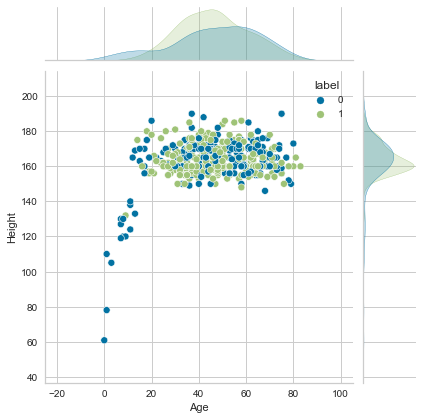

In [414]:
sns.jointplot(x="Age", 
              y="Height",
              hue="label",
             data=df_person)

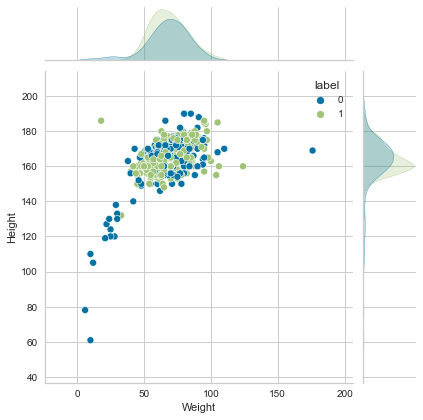

In [415]:
sns.jointplot(x="Weight", 
              y="Height",
              hue="label",
             data=df_person)

The above figures show that the distribution of age, height and weight of both normal and arrhythmia patients. As we can see, when the observation shifts from normal people and pateints, the peak of age shifts from 45 to around 60. When we check the heights, the peak shifts from 160 cm to 170 cm.
the summit of weights also moves from 60kg to 75 kg. It looks like people who are older, taller and heavier are slightly more likely to get arrthymia. 

In [416]:
len(df_person[(df_person['Sex'] == 0) & (df_person['label'] == 0)])/len(df_person[df_person['Sex'] == 0])

0.5812807881773399

In [417]:
len(df_person[(df_person['Sex'] == 1) & (df_person['label'] == 0)])/len(df_person[df_person['Sex'] == 1])

0.357429718875502

For all sampled women, 35% of them have arrhythmia. For all sampled men, 58% of them have arrhythmia.

In [418]:
len(df_person[(df_person['Sex'] == 0) & (df_person['label'] == 0)])/len(df_person[df_person['label'] == 0])

0.5700483091787439

In [419]:
len(df_person[(df_person['Sex'] == 1) & (df_person['label'] == 0)])/len(df_person[df_person['label'] == 0])

0.42995169082125606

Look at the population of samples who have arrhythmia, 57% of them are men and 43% of them are women. To me it seems like men are more likely to get arrhythmia.